# MT5 POC

In [3]:
from transformers import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install google.colab datasets transformers sentencepiece

In [4]:
from datasets import load_dataset
# from google.colab import driva
from IPython.display import display
from IPython.html import widgets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch

from torch import optim
from torch.nn import functional as F

import tqdm
# from tqdm import tqdm_notebook

from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

In [5]:
model_repo = 'google/mt5-small'
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

In [6]:
# Maximum tokens length the pre-trained model can handle
model.config.max_length

20

In [7]:
input = "Here is a test sentence"
token_ids = tokenizer.encode(input, return_tensors="pt")
if CUDA:
  token_ids = token_ids.cuda()
print(token_ids)

tensor([[10421,   339,   259,   262,  2978,   259, 98923,     1]],
       device='cuda:0')


In [8]:
model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[     0, 250099,      1]], device='cuda:0')
<pad> <extra_id_0></s>


In [9]:
example_input_string = "<jp>this is a test asdf"
input_ids = tokenizer.encode(example_input_string)
print("Input ids:", input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids)
print("Tokens:", tokens)

Input ids: [1042, 3889, 669, 860, 339, 259, 262, 2978, 527, 6386, 1]
Tokens: ['▁<', 'jp', '>', 'this', '▁is', '▁', 'a', '▁test', '▁as', 'df', '</s>']


In [10]:
type(tokenizer.vocab)

dict

## New Dataset: opus100

In [11]:
# !rm ./*
# !wget https://www2.nict.go.jp/astrec-att/member/mutiyama/ALT/ALT-Parallel-Corpus-20191206.zip
# !ls
# !unzip ALT-Parallel-Corpus-20191206.zip; rm ALT-Parallel-Corpus-20191206.zip
# !mv ALT-Parallel-Corpus-20191206/* ./;rm -r ALT-Parallel-Corpus-20191206 sample_data
# !rm ALT-O-COCOSDA.pdf ChangeLog.txt README.txt URL.txt

In [12]:
dataset_hi = load_dataset("opus100", "en-hi")
en_hi_train = dataset_hi['train']
en_hi_test = dataset_hi['test']
# dataset_zh = load_dataset("opus100", "en-zh")
# en_zh_train = dataset_zh['train']
# en_zh_test = dataset_zh['test']

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/534319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-hi/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
en_hi_train['translation'][:5]

[{'en': 'Other, Private Use', 'hi': 'अन्य, निज़ी उपयोग'},
 {'en': '[SCREAMING]', 'hi': 'ऊबड़ .'},
 {'en': 'Spouse', 'hi': 'जीवनसाथी'},
 {'en': 'I will never salute you!', 'hi': '- तुम एक कमांडर कभी नहीं होगा!'},
 {'en': 'and the stars and the trees bow themselves;',
  'hi': 'और तारे और वृक्ष सजदा करते है;'}]

In [14]:
source = []
target = []

for e in en_hi_train['translation'][:]:
  source.append(e['en'])
  target.append(e['hi'])

train_df = pd.DataFrame({
    'source': pd.Series(source),
    'target': pd.Series(target)
})

source = []
target = []

for e in en_hi_test['translation'][:]:
  source.append(e['en'])
  target.append(e['hi'])

test_df = pd.DataFrame({
    'source': pd.Series(source),
    'target': pd.Series(target)
})

In [15]:
train_df.head()

,source,target
0,"Other, Private Use","अन्य, निज़ी उपयोग"
1,[SCREAMING],ऊबड़ .
2,Spouse,जीवनसाथी
3,I will never salute you!,- तुम एक कमांडर कभी नहीं होगा!
4,and the stars and the trees bow themselves;,और तारे और वृक्ष सजदा करते है;


## Build data transformation pipeline

In [ ]:
# todo

## Old Pipeline

In [14]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("DATASET.txt", sep="\t", header=None, names=["target", "source"])
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)

(2580, 2) (287, 2)


## Prepare inputs

In [16]:
print(train_df.shape, test_df.shape)
print("Saving the train and test dataframes as csv...")
train_df.to_csv("en_hi_train.csv")
test_df.to_csv("en_hi_test.csv")
print("Done.")

(534319, 2) (2000, 2)
Saving the train and test dataframes as csv...
Done.


In [17]:
token_ids = tokenizer.encode(example_input_string, return_tensors="pt", padding="max_length", truncation=True, max_length=model.config.max_length)
print(token_ids)

tensor([[1042, 3889,  669,  860,  339,  259,  262, 2978,  527, 6386,    1,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


In [18]:
inputs = []
for d in train_df.source.items():
  inputs.append(tokenizer.encode(d[1], return_tensors="np", padding="max_length", truncation=True, max_length=model.config.max_length)[0])

outputs = []
for d in train_df.target.items():
  outputs.append(tokenizer.encode(d[1], return_tensors="np", padding="max_length", truncation=True, max_length=model.config.max_length)[0])

print(len(inputs), len(outputs))

534319 534319


In [19]:
input_pt = torch.tensor(inputs)
output_pt = torch.tensor(outputs)

if CUDA:
  input_pt = input_pt.cuda()
  output_pt = output_pt.cuda()

print(input_pt.shape)
print(output_pt.shape)

torch.Size([534319, 20])
torch.Size([534319, 20])


In [20]:
input_pt[:8].shape

torch.Size([8, 20])

In [21]:
# Constants
n_epochs = 8
batch_size = 16
print_freq = 50
checkpoint_freq = 100
lr = 5e-4
n_batches = int(np.ceil(len(train_df) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [22]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

In [23]:
losses = []

In [24]:
def get_data_generator(inputs, outputs, batch_size=16):
  # inputs = inputs.shuffle()
  # outputs = outputs.shuffle()

  for i in range(0, len(inputs), batch_size):
    input_batch = inputs[i:i+batch_size]
    output_batch = outputs[i:i+batch_size]
  
    yield (input_batch, output_batch)

In [25]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(input_pt, output_pt, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [26]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(input_pt, output_pt, batch_size)
                
  for batch_idx, (input_batch, label_batch) in tqdm.notebook.tqdm(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_df)
      print('Test loss of {:.3f}'.format(test_loss))
      # torch.save(model.state_dict(), model_path)

# torch.save(model.state_dict(), model_path)

  0%|          | 0/33395 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 38.586 | lr: 9.35979034069637e-06
Epoch: 1 | Step: 100 | Avg. loss: 32.202 | lr: 1.871958068139274e-05
Test loss of 28.508
Epoch: 1 | Step: 150 | Avg. loss: 28.492 | lr: 2.8079371022089103e-05
Epoch: 1 | Step: 200 | Avg. loss: 23.481 | lr: 3.743916136278548e-05
Test loss of 20.371
Epoch: 1 | Step: 250 | Avg. loss: 16.799 | lr: 4.679895170348184e-05
Epoch: 1 | Step: 300 | Avg. loss: 12.526 | lr: 5.6158742044178206e-05
Test loss of 10.945
Epoch: 1 | Step: 350 | Avg. loss: 10.550 | lr: 6.551853238487458e-05


KeyboardInterrupt: ignored

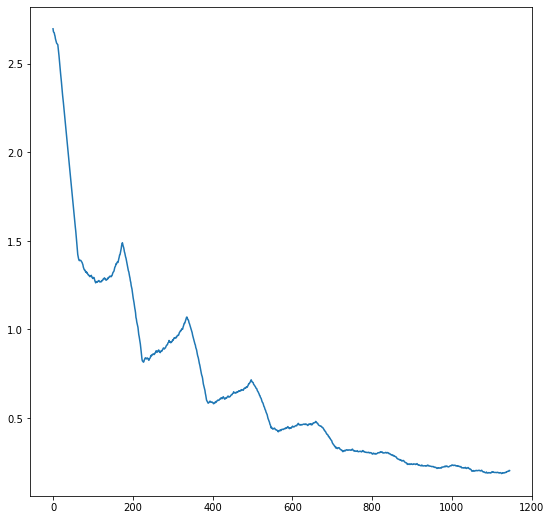

In [28]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.figure(figsize=(9, 9))
plt.plot(smoothed_losses[100:])

In [29]:
test_df.head().target.tolist()

['This car has been used for the past ten years.',
 'What time do you usually get up every morning?',
 'You are fortunate to have such loving parents.',
 'You had better not go out in this bad weather.',
 'You make mistakes if you do things in a hurry.']

In [30]:
id_to_test = 3
test_sentence_source = test_df.source.tolist()[id_to_test]
test_sentence_target = test_df.target.tolist()[id_to_test]
print("Input:")
print('Raw input text in Hindi:', test_sentence_source)
print('Expected text in English:', test_sentence_target)

input_ids = tokenizer.encode(test_sentence_source, return_tensors="pt", padding="max_length", truncation=True, max_length=model.config.max_length)[0]
input_ids = input_ids.unsqueeze(0).cuda()
# print(input_ids)
print()

# print('Truncated input text:', tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0])))
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_length=model.config.max_length)
# print(output_tokens)
print("Output:")
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True, padding="max_length", truncation=True, max_length=model.config.max_length))

Input:
Raw input text in Hindi: अच्छा होगा कि तुम इस बुरे मौसम में बाहर न जाओ।
Expected text in English: You had better not go out in this bad weather.

Output:
It's really cold here that bad weather is coming.
You have nothing but a bad weather like this.
I'm back to it when you are in this cold.


# Push to Model Hub

In [ ]:
from huggingface_hub import notebook_login

# notebook_login()

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
# repo_name = "mt5_hindi_to_english"
# model.push_to_hub(repo_name)
# model.config.push_to_hub(repo_name)
# tokenizer.push_to_hub(repo_name)

# Misc calculations

In [ ]:
!pip install --no-cache-dir transformers sentencepiece datasets

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

checkpoint = "google/mt5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
sequence = ["This is pretty good", "Okay"]
tokens = tokenizer(sequence, padding=True)
print(tokens)

In [ ]:
import pandas as pd

df = pd.read_csv("DATASET.txt", sep="\t")
df.head()

In [ ]:
df.ENG.astype(str).tolist()[:10]

In [ ]:
# Transform input tokens 
inputs = tokenizer("Hello world!", return_tensors="tf")

# Model apply
outputs = model(**inputs)

In [ ]:
import tensorflow as tf

sequences = df.ENG.astype(str).tolist()
batch = dict(tokenizer(sequences, padding=True, truncation=True, return_tensors="tf"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
labels = tf.convert_to_tensor(df.HIN.astype(str).tolist())
model.train_on_batch(batch, labels)

In [ ]:
# lang = "hi"
# hi_df = pd.read_csv("data_"+lang+".txt", sep="\t", header=None, names=["id", lang])
# lang = "zh"
# zh_df = pd.read_csv("data_"+lang+".txt", sep="\t", header=None, names=["id", lang])
# lang = "en"
# en_df = pd.read_csv("data_"+lang+".txt", sep="\t", header=None, names=["id", lang])

# print(en_df.size, en_df.shape)
# print(hi_df.size, hi_df.shape)
# print(zh_df.size, zh_df.shape)

# lang1 = "zh"
# lang2 = "hi"
# newFlag = True


# if (newFlag):
#   df = pd.DataFrame().assign(A=en_df['en'], C=hi_df['hi'], D=zh_df['zh'])
#   df.columns = ["en", "hi", "zh"]

#   df = df[[lang1, lang2]]
#   # df = df.sample(frac=1).reset_index(drop=True)
# else:
#   df = pd.read_csv("DATASET.txt", sep="\t", header=None, names=["target", "source"])

# df.columns = ["source", "target"]
# print(df.shape)
# df.iloc[100:105,:]

39816 (19908, 2)
39844 (19922, 2)
40212 (20106, 2)
(19908, 2)


,source,target
100,新芬党的马丁·麦吉尼斯表示：“如果民主统一党不准备在6月份开展工作或给出任何实质性的指示，那...,अगर DUP जून के दौरान काम करने या कोई ठोस संकेत...
101,“现实情况是，这两个最大的政党根本没有表现出他们准备向前迈进的意愿。”,व्यावहारिक वास्तविकता यह है कि दो सबसे बड़ी पा...
102,“民主统一党的推诿和小动作阻碍了进步的可能，让我们所有人都受到公众的嘲笑。”,DUP द्वारा प्रचलित और क्षुद्र प्रकोप प्रगति की...
103,星期一，伊恩·佩斯利要求将11月24日截止日期延长两周。,"सोमवार को, इयान पैस्ले ने 24 नवंबर की समय सीमा..."
104,这是英国首相托尼·布莱尔和爱尔兰总理伯蒂·埃亨计划的一部分，他们计划在2002年10月议会因...,यह ब्रिटिश प्रधान मंत्री टोनी ब्लेयर और आयरिश ...
